# Libraries

In [21]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt

# Data Collection

In [2]:
data = pd.read_csv("Historical_data.csv")
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head()

,Symbol,Date,Open,High,Low,Close,Volume,Market Cap,Time Open,Time High,Time Low,Time Close
0,BTC,2023-12-31,42152.098454,42860.937392,41998.255346,42265.185655,1.639750e+10,8.278112e+11,2023-12-31T00:00:00.000Z,2023-12-31T09:46:00.000Z,2023-12-31T02:53:00.000Z,2023-12-31T23:59:59.999Z
1,BTC,2023-12-30,42091.752644,42584.123640,41556.225992,42156.901150,1.601393e+10,8.256468e+11,2023-12-30T00:00:00.000Z,2023-12-30T16:18:00.000Z,2023-12-30T09:45:00.000Z,2023-12-30T23:59:59.999Z
2,BTC,2023-12-29,42614.643892,43124.325860,41424.060641,42099.402809,2.600002e+10,8.244842e+11,2023-12-29T00:00:00.000Z,2023-12-29T14:43:00.000Z,2023-12-29T22:21:00.000Z,2023-12-29T23:59:59.999Z
3,BTC,2023-12-28,43468.198063,43804.781418,42318.548862,42627.853531,2.299209e+10,8.347916e+11,2023-12-28T00:00:00.000Z,2023-12-28T00:39:00.000Z,2023-12-28T16:28:00.000Z,2023-12-28T23:59:59.999Z
4,BTC,2023-12-27,42518.468528,43683.159808,42167.583486,43442.854558,2.526094e+10,8.507208e+11,2023-12-27T00:00:00.000Z,2023-12-27T22:18:00.000Z,2023-12-27T03:34:00.000Z,2023-12-27T23:59:59.999Z


# Pre-processing

In [3]:
years = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
data['Date'] = pd.to_datetime(data['Date'])
data['Week'] = data['Date'].dt.isocalendar().week
# Add a column for the year to distinguish between the same week numbers across different years
# need to use iso because otherwise there is Year issue.
data['Year'] = data['Date'].dt.isocalendar().year
n = []
for y in years:
    d = y + '-12-31'
    l = data[(data['Date'] == d) & (data['Market Cap'] > 1000000)]
    sym = l.Symbol
    df = data[(data['Symbol'].isin(sym)) & (data['Year'] == (int)(y))]
    n.append(df)
newData = pd.concat(n)
newData.head()

,Symbol,Date,Open,High,Low,Close,Volume,Market Cap,Time Open,Time High,Time Low,Time Close,Week,Year
3290,BTC,2014-12-28,316.160004,320.028015,311.078003,317.239014,11676600.0,4.333390e+09,2014-12-28T00:00:00.000Z,2014-12-28T00:39:00.000Z,2014-12-28T11:39:01.000Z,2014-12-28T23:59:59.999Z,52,2014
3291,BTC,2014-12-27,327.583008,328.911011,312.630005,315.863007,15185200.0,4.313267e+09,2014-12-27T00:00:00.000Z,2014-12-27T00:19:00.000Z,2014-12-27T19:59:00.000Z,2014-12-27T23:59:59.999Z,52,2014
3292,BTC,2014-12-26,319.152008,331.424011,316.627014,327.924011,16410500.0,4.476704e+09,2014-12-26T00:00:00.000Z,2014-12-26T21:24:01.000Z,2014-12-26T02:59:00.000Z,2014-12-26T23:59:59.999Z,52,2014
3293,BTC,2014-12-25,322.286011,322.670013,316.958008,319.007996,9883640.0,4.353789e+09,2014-12-25T00:00:00.000Z,2014-12-25T00:24:01.000Z,2014-12-25T19:29:01.000Z,2014-12-25T23:59:59.999Z,52,2014
3294,BTC,2014-12-24,334.385010,334.740997,321.356995,322.533997,15092300.0,4.400638e+09,2014-12-24T00:00:00.000Z,2014-12-24T00:19:02.000Z,2014-12-24T21:44:01.000Z,2014-12-24T23:59:59.999Z,52,2014


In [4]:
data = newData
df = pd.DataFrame(data)
df.sort_values(by=["Symbol", "Year", "Week", "Date"], inplace=True)

# let us focus on last day
# Get the last day's weight for each group

df['Is Last Day'] = df.groupby(['Symbol', 'Year', 'Week'])['Date'].transform('max') == df['Date']

# Calculate the total market cap on the last day for each (Year, Week)
total_market_cap_last_day = df[df['Is Last Day']].groupby(['Year', 'Week'])['Market Cap'].sum().reset_index(name='Last Day Total Market Cap')

# Merge this total market cap back into the original DataFrame
df = pd.merge(df, total_market_cap_last_day, on=['Year', 'Week'], how='left')

# Calculate the corrected weight
df['Corrected Weight'] = df.apply(lambda row: row['Market Cap'] / row['Last Day Total Market Cap'] if row['Is Last Day'] else None, axis=1)

# Forward-fill the corrected weights within each (Symbol, Year, Week) group
df['Corrected Weight'] = df.groupby(['Symbol', 'Year', 'Week'])['Corrected Weight'].ffill()

df.head()

,Symbol,Date,Open,High,Low,Close,Volume,Market Cap,Time Open,Time High,Time Low,Time Close,Week,Year,Is Last Day,Last Day Total Market Cap,Corrected Weight
0,$MONG,2023-04-28,2.703192e-09,3.782203e-09,1.267824e-09,1.333718e-09,2420810.81,0.0,2023-04-28T00:00:00.000Z,2023-04-28T08:36:00.000Z,2023-04-28T19:00:00.000Z,2023-04-28T23:59:59.999Z,17,2023,False,1.249191e+12,NaN
1,$MONG,2023-04-29,1.333675e-09,2.826339e-09,7.508560e-10,2.733084e-09,1310786.96,0.0,2023-04-29T00:00:00.000Z,2023-04-29T23:58:00.000Z,2023-04-29T13:48:00.000Z,2023-04-29T23:59:59.999Z,17,2023,False,1.249191e+12,NaN
2,$MONG,2023-04-30,2.753259e-09,8.860236e-09,1.870047e-09,7.698647e-09,4419102.38,0.0,2023-04-30T00:00:00.000Z,2023-04-30T22:58:00.000Z,2023-04-30T05:54:00.000Z,2023-04-30T23:59:59.999Z,17,2023,True,1.249191e+12,0.0
3,$MONG,2023-05-01,7.633896e-09,6.478517e-08,7.014199e-09,4.735458e-08,29865588.61,0.0,2023-05-01T00:00:00.000Z,2023-05-01T23:01:00.000Z,2023-05-01T00:13:00.000Z,2023-05-01T23:59:59.999Z,18,2023,False,1.224695e+12,NaN
4,$MONG,2023-05-02,4.803409e-08,9.417955e-08,4.208069e-08,5.330575e-08,28763403.06,0.0,2023-05-02T00:00:00.000Z,2023-05-02T12:13:00.000Z,2023-05-02T00:28:00.000Z,2023-05-02T23:59:59.999Z,18,2023,False,1.224695e+12,NaN


In [5]:
'''
Now that we have the Week and Year column, we need to calculate the weekly return
and store the last day of the week's price, weight .
This section of the code focuses on that
'''
#data = df
data = pd.DataFrame(df)
data['Date'] = pd.to_datetime(data['Date'])
#data.set_index('Date', inplace=True)
data.sort_values(by=["Symbol", "Year", "Week", "Date"], inplace=True)


# Group by the new 'Year' and 'Week' columns
grouped = data.groupby(['Symbol', 'Year', 'Week'])

# Calculate weekly return for each group
t = grouped.apply(lambda x: ((x['Close'].iloc[-1] - x['Close'].iloc[0]) / x['Close'].iloc[0]) )
t.name = 'Weekly Return'

# Get the last day's weight for each group
last_day_weights = grouped.apply(lambda x: x['Corrected Weight'].iloc[-1])
last_day_weights.name = 'Weight'

# Get the last day's Market Cap for each group as wel
last_day_mc = grouped.apply(lambda x: x['Market Cap'].iloc[-1])
last_day_mc.name = 'Market Cap'

# Combine the results into a new DataFrame
results = pd.DataFrame(t).join(last_day_weights).reset_index()

# Extracting the last close price for each group
last_close_prices = grouped.apply(lambda x: x['Close'].iloc[-1])
last_close_prices.name = 'Last Close'

# Combine all the results into a new DataFrame
results = pd.DataFrame({
    'Weekly Returns': t,
    'Last Close': last_close_prices,
    'Last Day Weight': last_day_weights,
    'Market Cap': last_day_mc
}).reset_index()

results.head()

/var/folders/6n/xjznq69x05l4v5yr5j15rnt40000gn/T/ipykernel_63941/2146790467.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  t = grouped.apply(lambda x: ((x['Close'].iloc[-1] - x['Close'].iloc[0]) / x['Close'].iloc[0]) )
/var/folders/6n/xjznq69x05l4v5yr5j15rnt40000gn/T/ipykernel_63941/2146790467.py:12: RuntimeWarning: invalid value encountered in scalar divide
  t = grouped.apply(lambda x: ((x['Close'].iloc[-1] - x['Close'].iloc[0]) / x['Close'].iloc[0]) )


,Symbol,Year,Week,Weekly Returns,Last Close,Last Day Weight,Market Cap
0,$MONG,2023,17,4.772319,7.698647e-09,0.0,0.0
1,$MONG,2023,18,3.449782,2.107175e-07,0.0,0.0
2,$MONG,2023,19,-0.371659,8.407849e-08,0.0,0.0
3,$MONG,2023,20,0.169884,1.012385e-07,0.0,0.0
4,$MONG,2023,21,-0.231880,5.245384e-08,0.0,0.0


In [6]:
'''
Now it is time to winsorize the data as the returns are extremly volatile.
The paper does not specify how it is winsorizing the returns. I will simply
group by symbol and winsorize
'''
def winsorize_returns(group, limits=0.00005):
    group['Winsorized Returns'] = winsorize(group['Weekly Returns'], limits=(limits, limits))
    return group

# Apply the function to each symbol's group
winsorized_weekly_data = results.groupby('Symbol').apply(winsorize_returns)
winsorized_weekly_data = winsorized_weekly_data.reset_index(drop=True)
winsorized_weekly_data.head()

,Symbol,Year,Week,Weekly Returns,Last Close,Last Day Weight,Market Cap,Winsorized Returns
0,$MONG,2023,17,4.772319,7.698647e-09,0.0,0.0,4.772319
1,$MONG,2023,18,3.449782,2.107175e-07,0.0,0.0,3.449782
2,$MONG,2023,19,-0.371659,8.407849e-08,0.0,0.0,-0.371659
3,$MONG,2023,20,0.169884,1.012385e-07,0.0,0.0,0.169884
4,$MONG,2023,21,-0.231880,5.245384e-08,0.0,0.0,-0.231880


In [7]:
'''
This is the pre-processed data. We will store in the csv file just in case we potentially
crash the jupyter notebook. 
'''
winsorized_weekly_data.to_csv("PaperSubmissionCleanedData.csv")

<h1><center> Paper Replication </center></h1>

# J/K Methodology

In [8]:
# Reading the data
data = pd.read_csv("PaperSubmissionCleanedData.csv")
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head(13)

,Symbol,Year,Week,Weekly Returns,Last Close,Last Day Weight,Market Cap,Winsorized Returns
0,$MONG,2023,17,4.772319,7.698647e-09,0.000000,0.00,4.772319
1,$MONG,2023,18,3.449782,2.107175e-07,0.000000,0.00,3.449782
2,$MONG,2023,19,-0.371659,8.407849e-08,0.000000,0.00,-0.371659
3,$MONG,2023,20,0.169884,1.012385e-07,0.000000,0.00,0.169884
4,$MONG,2023,21,-0.231880,5.245384e-08,0.000000,0.00,-0.231880
5,$MONG,2023,22,-0.620434,1.652147e-08,0.000008,9602213.91,-0.620434
6,$MONG,2023,23,-0.178290,1.173797e-08,0.000006,6822064.00,-0.178290
7,$MONG,2023,24,0.583100,1.600907e-08,0.000008,9304408.93,0.583100
8,$MONG,2023,25,0.381314,2.147719e-08,0.000010,12482458.29,0.381314
9,$MONG,2023,26,0.083492,2.008442e-08,0.000009,11672985.29,0.083492


In [9]:
# Calculating the log return since it is easier
data['Log Winsorized Returns'] =  np.log(data['Winsorized Returns'] + 1)
data = data.rename(columns={'Last Close': 'Close_last', 'Last Day Weight' :'Weight'})
data.head()

/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Symbol,Year,Week,Weekly Returns,Close_last,Weight,Market Cap,Winsorized Returns,Log Winsorized Returns
0,$MONG,2023,17,4.772319,7.698647e-09,0.0,0.0,4.772319,1.753074
1,$MONG,2023,18,3.449782,2.107175e-07,0.0,0.0,3.449782,1.492855
2,$MONG,2023,19,-0.371659,8.407849e-08,0.0,0.0,-0.371659,-0.464672
3,$MONG,2023,20,0.169884,1.012385e-07,0.0,0.0,0.169884,0.156904
4,$MONG,2023,21,-0.231880,5.245384e-08,0.0,0.0,-0.231880,-0.263809


In [ ]:
# Calculate cumulative returns for each symbol
df_filtered['Cumulative Log Return'] = df_filtered.groupby('Symbol')['Log Winsorized Returns'].transform(lambda x: np.prod(1 + x) - 1)

# Aggregate to get one row per symbol
df_sorted = last_cumulative_returns[['Symbol', 'c']].drop_duplicates().sort_values(by='c')

## Helper Functions
---

We need to create a few helper functions as that would make writing the code much more easier

In [11]:
'''
Helper Functions
'''

def get_previous_weeks(year, week, J):
    '''
        Function to handle year transition and generate weeks and years.
        When are looking back J weeks, it is possible that we go to a previous
        year(s). We need to handle that.
        This function returns all the previous J weeks based on the current week
        and year
    '''
    weeks = []
    for i in range(J):
        if week - 1 < 1:
            week = 53
            year -= 1
        else:
            week -= 1
        weeks.append((year, week))
    return pd.DataFrame(weeks, columns=['Year', 'Week'])

In [12]:
def adjust_week_year(start_week, start_year, K):
    """
    Adjust the end week and year based on the holding period K.
    
    Parameters:
    - start_week: The starting week number.
    - start_year: The starting year.
    - K: Holding period in weeks.
    
    Returns:
    - Tuple of (end_week, end_year) after adjustment.
    """
    end_week = start_week + K
    end_year = start_year
    
    if end_week > 53:
        end_week -= 53  # Adjust for the next year
        end_year += 1   # Increment the year
    
    return end_week, end_year

In [13]:
def prevJWeeksWinnersLosers(sW, sY, J, data):
    '''
    This function returns the winners and losers based on J sorting weeks
    '''
    # get dataframe of past J weeks
    previous_weeks = get_previous_weeks(sY, sW, J)
    # filter the data based on this time frame
    df_filtered = pd.merge(data, previous_weeks, on=['Year', 'Week'], how='inner')
    # Calculate cumulative returns for each symbol
    df_filtered['Cumulative Log Return'] = df_filtered.groupby('Symbol')['Log Winsorized Returns'].transform(lambda x: np.prod(1 + x) - 1)
    # Aggregate to get one row per symbol
    df_sorted = df_filtered[['Symbol', 'Cumulative Log Return']].drop_duplicates().sort_values(by='Cumulative Log Return')
    # There can be some outlier values, so we need to drop them
    df_sorted = df_sorted.replace([np.inf, -np.inf], np.nan).dropna()
    # Top 30% winners, bottom 30% losers
    winners, losers = df_sorted[(int) (7 * len(df_sorted)/10):], df_sorted[0: (int) (3*len(df_sorted)/10) + 1]
    return winners, losers, df_sorted

In [14]:
def getUniverseWeights(iW, iY, J, investment, data):
    '''
    Once we have the winners and the losers, we also need to calculate the 
    weights for each individual assests

    iW: Week
    iY: Year
    J: number of weeks we need to look back
    investment: amount of money to be invested
    data: crypto-universe

    It returns our universe of coins with the weights associated and the coins 
    that were excluded
    '''
    
    # We need to now look at the winners and losers of the ending time
    # data here is the data we read from the file
    winners, losers, d = prevJWeeksWinnersLosers(iW, iY, J, data)
    
    # Keeping track of the symbols for the end date for the rebalance
    winner_symbols = winners.Symbol
    loser_symbols = losers.Symbol
    d_symbols = d.Symbol

    w_starting_price = []
    l_starting_price = []

    # Selling price of winner coins
    w_starting_price = data[(data['Year'] == iY) & 
    (data['Week'] == iW) & (data['Symbol'].isin(winner_symbols))][['Symbol', 'Close_last','Weight', 'Market Cap']]
    # Selling pricer of loser coins
    l_starting_price = data[(data['Year'] == iY) & 
    (data['Week'] == iW) & (data['Symbol'].isin(loser_symbols))][['Symbol', 'Close_last', 'Weight', 'Market Cap']]
    
    d_starting_price = data[(data['Year'] == iY) & 
    (data['Week'] == iW) & (data['Symbol'].isin(d_symbols))][['Symbol', 'Close_last','Weight', 'Market Cap']]

    # merging the dataframes with the new information
    winners = pd.merge(winners, w_starting_price, on='Symbol')
    losers = pd.merge(losers, l_starting_price, on='Symbol')
    d= pd.merge(d, d_starting_price, on='Symbol')

    # If the last price is zero, we will exclude them because potentially they were rugs
    # Plus division by zero error
    winners = winners[winners['Close_last'] != 0]
    losers = losers[losers['Close_last'] != 0]

    # calculating individal loser and winner net marketcap
    winners_total_market_cap = winners['Market Cap'].sum()
    losers_total_market_cap = losers['Market Cap'].sum()

    # total market cap of our universe
    total_market_cap = winners_total_market_cap + losers_total_market_cap

    # calculating the weights of all assets involved
    winners['Weight'] =  winners['Market Cap'] / total_market_cap
    losers['Weight'] = losers['Market Cap'] / total_market_cap 

    # Calculating number of stocks that will be bought based on weight
    winners['totalStocksBought'] = (winners['Weight'] * investment)/ winners['Close_last'] 
    losers['totalStocksBought'] = (losers['Weight'] * investment) / losers['Close_last'] * (-1)


    # Combining the losers and winners into one
    uni = [winners[['Symbol', 'Close_last', 'totalStocksBought', 'Weight']], losers[['Symbol', 'Close_last', 'totalStocksBought', 'Weight']]]
    universe = pd.concat(uni)

    return universe.dropna(), d


In [15]:
def rebalancePortfolio(starting_universe, ending_universe, d_end):
    '''
        We now know the initial number of coins that were bought for each crypto
        We also know the target number.
        We shall now re-balance the portfolio.
        This happens after the K holding period is over
    '''
    starting_symbols = starting_universe.Symbol.tolist()
    ending_symbols = ending_universe.Symbol.tolist()
    transaction = pd.DataFrame(columns = ['Symbol', 'InitialQty', 'BuyingPrice','FinalWeight' ,'FinalQty', 'FinalPrice'])
    
    if(len(starting_symbols) != 0 and len(ending_symbols) != 0):
        for s in starting_symbols:
            # We will first look at all coins from starting universe
            initialInfo = starting_universe.loc[starting_universe['Symbol'] == s]
            initialQty = initialInfo['totalStocksBought'].values[0]
            initialPrice = initialInfo['Close_last'].values[0]
            if s not in ending_symbols:
                # That stock does not exist so we should get rid of our position. Which means selling everything
                price = d_end.loc[d_end['Symbol'] == s, 'Close_last']
                if(len(price) == 0):
                    # There is some missing data which causes some discrepency
                    continue
                transaction.loc[len(transaction.index)] = [s, initialQty,initialPrice, 0, 0, price.values[0]]
            else:
                finalInfo = ending_universe.loc[ending_universe['Symbol'] == s]
                finalQty = finalInfo['totalStocksBought'].values[0]
                price = finalInfo['Close_last'].values[0]
                weight = finalInfo['Weight'].values[0]
                transaction.loc[len(transaction.index)] = [s, initialQty,initialPrice, weight, finalQty, price]

        # We also have to look at Symbols which were earlier not present in starting universe but end up
        for e in ending_symbols:
            finalInfo = ending_universe.loc[ending_universe['Symbol'] == e]
            finalQty = finalInfo['totalStocksBought'].values[0]
            finalPrice = finalInfo['Close_last'].values[0]
            weight = finalInfo['Weight'].values[0]
            if e not in starting_symbols:
                # That stock did not exist initially in the portfolio, but we will add it now
                transaction.loc[len(transaction.index)] = [e, 0,0, weight, finalQty, finalPrice]
        return transaction
    else:
        return None
        

In [16]:
def calculate_profit_closing_positions(transactions):
    '''
    This function calculates the profit/loss based on our positions
    We close all our positions before rebalancing
    
    We also want to ensure a couple of things:
    1. Long winners
    2. Short losers
    
    '''

    net_profit = 0  # Track net profit or loss

    for index, row in transactions.iterrows():
        # Skip if no initial quantity or final price is zero to avoid division by zero error
        if row['InitialQty'] == 0 :
            continue

        # We will close all positions

        # crypto-currencies have a unique scenario where a lot of get unlisted so final price would be 0
        # in that case, the short and long positions would be useless. We are treating them as a loss

        if row['FinalPrice'] == 0:
            net_profit += -abs(row['InitialQty']) * row['BuyingPrice']
            continue
        if row['InitialQty'] > 0:
            # long position. 
            profit_loss = row['InitialQty'] * (row['FinalPrice'] - row['BuyingPrice'])
        else:
            # short position
            profit_loss = abs(row['InitialQty']) * (row['BuyingPrice'] - row['FinalPrice'])
        net_profit += profit_loss
    return net_profit

In [26]:
def calculate_weekly(transactions):
    '''
    This function calculates the profit/loss that occurs during the weekly balancing
    '''
    net_profit = 0  # Track net profit or loss

    for index, row in transactions.iterrows():
        # Skip if no initial quantity or final price is zero to avoid division by zero error
        if row['InitialQty'] == 0 :
            continue
    
        if row['FinalPrice'] == 0:
            net_profit += -abs(row['InitialQty']) * row['BuyingPrice']
            continue
            
        if row['InitialQty'] > 0:
            # long position. 
            if row['FinalQty'] < row['InitialQty']:
                # we need to sell stockls
                profit_loss = abs(row['InitialQty'] - row['FinalQty'] ) * (row['FinalPrice'] - row['BuyingPrice'])
                net_profit += profit_loss
        else:
            # short position
            if abs(row['FinalQty']) < abs(row['InitialQty']):
                # we need to rebalamce further
                profit_loss = (abs(row['InitialQty']) - abs(row['FinalQty']) ) * (row['BuyingPrice'] - row['FinalPrice'])
                net_profit += profit_loss
    return net_profit

In [41]:
def getUniverseWeights(iW, iY, J, investment, data, getWinner = True):
    '''
    Once we have the winners and the losers, we also need to calculate the 
    weights for each individual assests

    iW: Week
    iY: Year
    J: number of weeks we need to look back
    investment: amount of money to be invested
    data: crypto-universe
    getWinner: return loser or winner

    It returns our winners/losers of coins with the weights associated and the coins 
    that were excluded
    '''
    # We need to now look at the winners and losers of the ending time
    # data here is the data we read from the file
    winners, losers, d = prevJWeeksWinnersLosers(iW, iY, J, data)
    
    # Keeping track of the symbols for the end date for the rebalance
    winner_symbols = winners.Symbol
    loser_symbols = losers.Symbol
    d_symbols = d.Symbol

    w_starting_price = []
    l_starting_price = []

    # Selling price of winner coins
    w_starting_price = data[(data['Year'] == iY) & 
    (data['Week'] == iW) & (data['Symbol'].isin(winner_symbols))][['Symbol', 'Close_last','Weight', 'Market Cap']]
    # Selling pricer of loser coins
    l_starting_price = data[(data['Year'] == iY) & 
    (data['Week'] == iW) & (data['Symbol'].isin(loser_symbols))][['Symbol', 'Close_last', 'Weight', 'Market Cap']]
    
    d_starting_price = data[(data['Year'] == iY) & 
    (data['Week'] == iW) & (data['Symbol'].isin(d_symbols))][['Symbol', 'Close_last','Weight', 'Market Cap']]

    
    winners = pd.merge(winners, w_starting_price, on='Symbol')
    losers = pd.merge(losers, l_starting_price, on='Symbol')
    d= pd.merge(d, d_starting_price, on='Symbol')
    
    winners = winners[winners['Close_last'] != 0]
    losers = losers[losers['Close_last'] != 0]
    
    winners_total_market_cap = winners['Market Cap'].sum()
    losers_total_market_cap = losers['Market Cap'].sum()

    total_market_cap = winners_total_market_cap + losers_total_market_cap
    winners['Weight'] =  winners['Market Cap'] / total_market_cap
    losers['Weight'] = losers['Market Cap'] / total_market_cap 

    # print(winners['Weight'].sum() + losers['Weight'].sum())
    
    # Calculating number of stocks that will be bought based on weight
    winners['totalStocksBought'] = (winners['Weight'] * investment)/ winners['Close_last'] 
    losers['totalStocksBought'] = (losers['Weight'] * investment) / losers['Close_last'] * (-1)


    # Combining the losers and winners into one
    uni = [winners[['Symbol', 'Close_last', 'totalStocksBought', 'Weight']], losers[['Symbol', 'Close_last', 'totalStocksBought', 'Weight']]]
    universe = pd.concat(uni)
    if getWinner:
        return winners[['Symbol', 'Close_last', 'totalStocksBought', 'Weight']], d
    else:
        return losers[['Symbol', 'Close_last', 'totalStocksBought', 'Weight']], d


---

# Implementing the Strategy (from 2014 to 2020)

First part of the paper focuses on different values of J and K = 1

In [ ]:
overallJKRebal = pd.DataFrame(columns = ['J','K','Initital Investment', 'Profit (Stock Diff)'])

for j in range(1,105):
    initialInvestmentW = 1000
    # This line is just here for sanity, you can comment it out if you want. Lets us know code is 
    # still running
    print(j)

    # J wi
    J = j
    K = 1

    # starting date
    sY = 2014
    sW = 1

    # ending date
    eW = 52
    eY = 2020
    
    iY = 2014
    iW = 1
    if(iW - J) <= 0:
        iW = J + 1
        if iW > 53:
            iW -= 53
            iY = iY + 1
    
    tempP = 1000
    
    p = 0
    
    transactions = None
    total = 0
    totalP = 0 

    # We need to rebalance which means we need a starting point and a target
    # point
    starting_universe, d_start = getUniverseWeights(iW, iY, J, 1000, data)
    while iW < eW or iY < eY:
        if(starting_universe is None):
            print('Here')
            iW, iY = adjust_week_year(iW, iY, K)
            continue
        sW = iW
        sY = iY
        iW, iY = adjust_week_year(iW, iY, K)
        
        #print(sY, '/', sW, ' to ', iY, '/', iW ) # Sanity check line, can comment out

        # let us now get the ending universe of stocks. Our investment will always be 1000.
        # this is our assumption
        ending_universe, d_end = getUniverseWeights(iW, iY, J, 1000, data)
        
        # Now we will look at rebalancing it
        transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
        if transactions is not None:
            # transaction holds the value of changes to be made
            #p, q, l = calculate_profit(transactions)
            p = calculate_profit_closing_positions(transactions)
            total = total + 1
            totalP = totalP + p
            initialInvestmentW += p
            if (p < 0):
                tempP = tempP + abs(p)
            
           # print( ' Profit = $', p, ' Investment for this now: ', initialInvestmentW, ' Current Profit = $', totalP)
        # POST REBALANCING
        starting_universe = ending_universe
        
    iW, iY = adjust_week_year(iW, iY, K)
    # we now need to close off our final positions
    ending_universe, d_end = getUniverseWeights(iW, iY, J, initialInvestmentW, data)
    transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
    if transactions is not None:
        # transaction holds the value of changes to be made
        p = calculate_profit_closing_positions(transactions)
        total = total + 1
        totalP = totalP + p
        if (p < 0):
            tempP = tempP + abs(p)
        #qq = transactions
            
    
    overallJKRebal.loc[len(overallJKRebal.index)] = [J, K, tempP, totalP]
    overallJKRebal.to_csv('PaperSubmissionJ=1_104K=1.csv')
    print('------------')

In [19]:
# Time to calculate the returns
overallJKRebal['Return (Stock Diff)'] = overallJKRebal['Profit (Stock Diff)'] / (overallJKRebal['Initital Investment'])

overallJKRebal.head()

,J,K,Initital Investment,Profit (Stock Diff),Return (Stock Diff)
0,1.0,1.0,10757.201752,5775.437579,0.536890
1,2.0,1.0,13101.651241,2680.678033,0.204606
2,3.0,1.0,12743.587778,3246.750549,0.254775
3,4.0,1.0,12441.405715,2259.383752,0.181602
4,5.0,1.0,12227.296891,2351.991639,0.192356


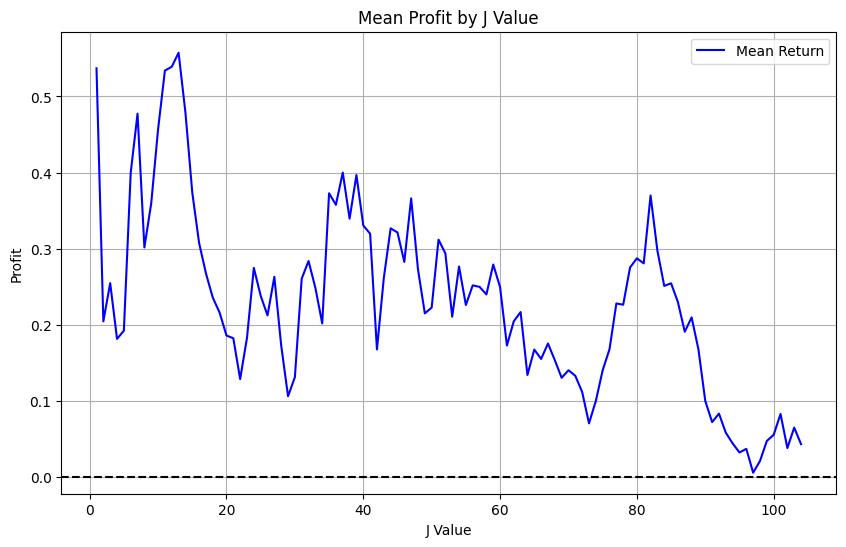

In [22]:
# Lets plot the returns
grouped_data = overallJKRebal.groupby('J')['Return (Stock Diff)'].agg(['mean', 'count', 'std'])
confidence_level = 0.95

plt.figure(figsize=(10, 6))
plt.plot(grouped_data.index, grouped_data['mean'], '-', color='b', label='Mean Return')
plt.xlabel('J Value')
plt.ylabel('Profit')
plt.title('Mean Profit by J Value')
plt.axhline(y=0, color='k', linestyle='--')  # Adds a horizontal line at zero for reference
plt.legend()
plt.grid(True)
plt.show()

# Replication of Average returns on J/K strategies with weekly rebalancing
---

In [ ]:
overall = pd.DataFrame(columns = ['J','K','Initital Investment', 'Profit'])
J = [1, 2, 4, 6, 8, 10, 12]
K = [1, 2, 4, 6, 8, 10, 12]
for j in J:
    JJ = j
    for k in K:
        initialInvestmentW = 1000
        initialInvestment = 1000
        print(j, k)
        KK = k
        eW = 53
        eY = 2020
        
        iY = 2014
        iW = 1
        if(iW - JJ) < 0:
            iW = JJ + 1
            if iW > 53:
                iW -= 53
                iY = iY + 1
                
        tempP = 1000
        p = 0

        transactions = None
        total = 0
        totalP = 0 
        
        starting_universe, d_start = getUniverseWeights(iW, iY, JJ, 1000, data)
        while (iW < eW and iY < eY) or iY <= eY:
            if(starting_universe is None):
                print('Here')
                iW, iY = adjust_week_year(iW, iY, KK)
                continue
            sW = iW
            sY = iY

            # This part of the code will focus on weekly rebalancing
            for week in range(KK):
                iW += 1  # Move to the next week
                if iW > 53:
                    iW = 1
                    iY += 1
                #print('Weekly: ', sY, '/', sW, ' to ', iY, '/', iW )
                weekly_universe, d_end = getUniverseWeights(iW, iY, JJ, 1000, data)
                transactions = rebalancePortfolio(starting_universe, weekly_universe, d_end)
                if transactions is not None:
                    p = calculate_weekly(transactions)
                    totalP = totalP + p
                    initialInvestmentW += p
                    if (p < 0):
                        tempP = tempP + abs(p)
                    qq = transactions
                starting_universe = weekly_universe
            
            # This part of the code focuses on closing the final positions
            iW, iY = adjust_week_year(sW, sY, KK)
            #print(sY, '/', sW, ' to ', iY, '/', iW )
    
            # let us now get the ending universe of stocks
            ending_universe, d_end = getUniverseWeights(iW, iY, JJ, 1000, data)
            
            # Now we will look at rebalancing it
            transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
            if transactions is not None:
                # transaction holds the value of changes to be made
                #p, q, l = calculate_profit(transactions)
                p = calculate_profit_closing_positions(transactions)
                total = total + 1
                totalP = totalP + p
                initialInvestmentW += p
                if (p < 0):
                    tempP = tempP + abs(p)
                qq = transactions
                
               # print( ' Profit = $', p, ' Investment for this now: ', initialInvestmentW, ' Current Profit = $', totalP)
            # POST REBALANCING
            starting_universe = ending_universe
            
        iW, iY = adjust_week_year(iW, iY, KK)
        # we now need to close off our final positions
        ending_universe, d_end = getUniverseWeights(iW, iY, JJ, 1000, data)
        transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
        if transactions is not None:
            # transaction holds the value of changes to be made
            p = calculate_profit_closing_positions(transactions)
            total = total + 1
            totalP = totalP + p
            if (p < 0):
                    tempP = tempP + abs(p)
            #qq = transactions
        overall.loc[len(overall.index)] = [ JJ, KK, tempP, totalP]
        overall.to_csv('PaperSubmissionMultipleJ=1_12,k=1_12_.csv')

In [30]:
overall['Return'] = overall['Profit'] / overall['Initital Investment']
overall_p = overall[['J','K','Return']]

In [31]:
pivoted_return = overall_p.pivot(index='J', columns='K', values='Return')
pivoted_return

K,1.0,2.0,4.0,6.0,8.0,10.0,12.0
J,,,,,,,
1.0,0.297458,0.318080,0.360501,0.343439,0.357663,0.340996,0.413086
2.0,-0.008628,-0.005948,-0.031030,-0.063852,-0.021705,0.061240,-0.049884
4.0,0.202791,0.201883,0.276093,0.232841,0.318544,0.318673,0.244366
6.0,0.416665,0.415792,0.500004,0.497646,0.558184,0.519991,0.511470
8.0,0.348316,0.345157,0.450685,0.514378,0.431946,0.566482,0.455340
10.0,0.406278,0.405542,0.500383,0.465343,0.553441,0.469430,0.544564
12.0,1.061094,1.058638,1.217482,1.181357,1.295736,1.265951,1.312615


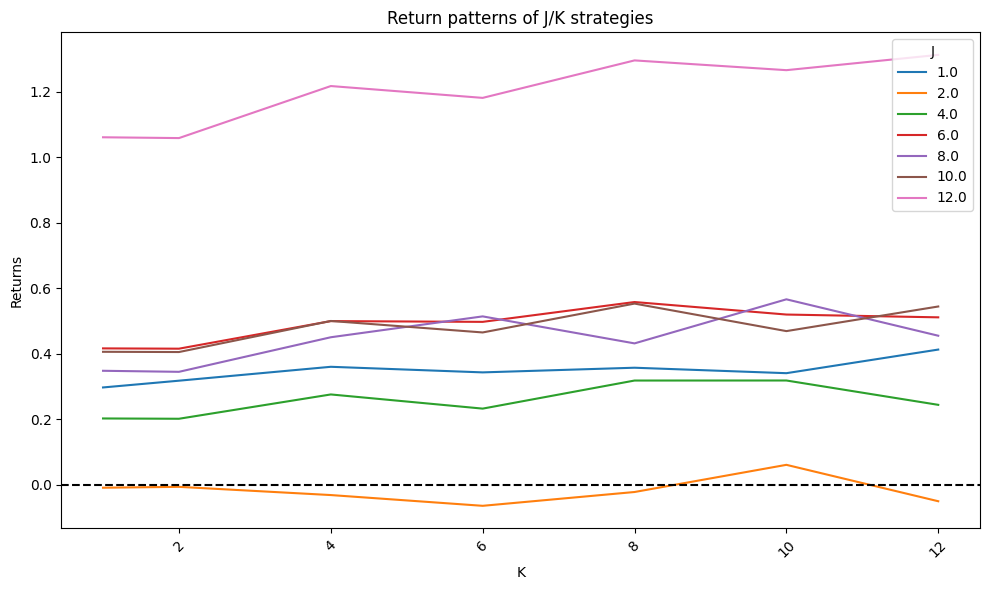

In [32]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for category, group_df in overall_p.groupby('J'):
    ax.plot(group_df['K'], group_df['Return'], label=category)

ax.set_title('Return patterns of J/K strategies')
ax.set_xlabel('K')
ax.set_ylabel('Returns')
ax.legend(title='J')
plt.xticks(rotation=45)
plt.axhline(y=0.0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# Replication of Winners and Losers, Seperately
---

In [ ]:
longWinners = pd.DataFrame(columns = ['J','K','Initital Investment', 'Profit'])
J = [1, 2, 4, 6, 8, 10, 12]
K = [1, 2, 4, 6, 8, 10, 12]
for j in J:
    JJ = j
    for k in K:
        initialInvestmentW = 1000
        initialInvestment = 1000
        print(j, k)
        KK = k
        eW = 52
        eY = 2020
        
        iY = 2014
        iW = 1
        if(iW - JJ) < 0:
            iW = JJ + 1
            if iW > 53:
                iW -= 53
                iY = iY + 1
        
        tempP = 1000
        tempL = 1000
        p = 0
        q = 0
        pQ = 0

        transactions = None
        total = 0
        totalP = 0 
        totalQ = 0
        totalL = 0
        starting_universe, d_start = getUniverseWeights(iW, iY, JJ, 1000, data, True)
        while (iW < eW and iY < eY) or iY <= eY:
            if(starting_universe is None):
                print('Here')
                iW, iY = adjust_week_year(iW, iY, KK)
                continue
            sW = iW
            sY = iY
            iW, iY = adjust_week_year(iW, iY, KK)
            #print(sY, '/', sW, ' to ', iY, '/', iW )
    
            # let us now get the ending universe of stocks
            ending_universe, d_end = getUniverseWeights(iW, iY, JJ, 1000, data, True)
            # Now we will look at rebalancing it
            transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
            if transactions is not None:
                # transaction holds the value of changes to be made
                #p, q, l = calculate_profit(transactions)
                p = calculate_profit_closing_positions(transactions)
                total = total + 1
                totalP = totalP + p
                totalQ = totalQ + q
                initialInvestmentW += p
                if (p < 0):
                    tempP = tempP + abs(p)
                qq = transactions
                
                # initialInvestmentW = initialInvestmentW + q
                #print( ' Profit = $', p, ' Investment for this now: ', initialInvestmentW, ' Current Profit = $', totalP)
            # POST REBALANCING
            starting_universe = ending_universe
            
        iW, iY = adjust_week_year(iW, iY, KK)
        # we now need to close off our final positions
        ending_universe, d_end = getUniverseWeights(iW, iY, JJ, initialInvestmentW, data, True)
        transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
        if transactions is not None:
            # transaction holds the value of changes to be made
            p = calculate_profit_closing_positions(transactions)
            total = total + 1
            totalP = totalP + p
            totalQ = totalQ + q
            
            if (p < 0):
                    tempP = tempP + abs(p)
            #qq = transactions
        longWinners.loc[len(longWinners.index)] = [ JJ, KK, tempP, totalP]
        longWinners.to_csv('PaperSSubmissionLongWinnersMultipleJ=1_12,k=1_12_.csv')

In [ ]:
longLosers = pd.DataFrame(columns = ['J','K','Initital Investment', 'Profit'])
J = [1, 2, 4, 6, 8, 10, 12]
K = [1, 2, 4, 6, 8, 10, 12]
for j in J:
    JJ = j
    for k in K:
        initialInvestmentW = 1000
        initialInvestment = 1000
        print(j, k)
        KK = k
        eW = 52
        eY = 2020
        
        iY = 2014
        iW = 1
        if(iW - JJ) < 0:
            iW = JJ + 1
            if iW > 53:
                iW -= 53
                iY = iY + 1
        
        tempP = 1000
        tempL = 1000
        p = 0
        q = 0
        pQ = 0

        transactions = None
        total = 0
        totalP = 0 
        totalQ = 0
        totalL = 0
        starting_universe, d_start = getUniverseWeights(iW, iY, JJ, 1000, data, False)
        while (iW < eW and iY < eY) or iY <= eY:
            if(starting_universe is None):
                print('Here')
                iW, iY = adjust_week_year(iW, iY, KK)
                continue
            sW = iW
            sY = iY
            iW, iY = adjust_week_year(iW, iY, KK)
            #print(sY, '/', sW, ' to ', iY, '/', iW )
    
            # let us now get the ending universe of stocks
            ending_universe, d_end = getUniverseWeights(iW, iY, JJ, 1000, data, False)
            # Now we will look at rebalancing it
            transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
            if transactions is not None:
                # transaction holds the value of changes to be made
                #p, q, l = calculate_profit(transactions)
                p = calculate_profit_closing_positions(transactions)
                total = total + 1
                totalP = totalP + p
                totalQ = totalQ + q
                initialInvestmentW += p
                if (p < 0):
                    tempP = tempP + abs(p)
                qq = transactions
                
                # initialInvestmentW = initialInvestmentW + q
               # print( ' Profit = $', p, ' Investment for this now: ', initialInvestmentW, ' Current Profit = $', totalP)
            # POST REBALANCING
            starting_universe = ending_universe
            
        iW, iY = adjust_week_year(iW, iY, KK)
        # we now need to close off our final positions
        ending_universe, d_end = getUniverseWeights(iW, iY, JJ, initialInvestmentW, data, False)
        transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
        if transactions is not None:
            # transaction holds the value of changes to be made
            p = calculate_profit_closing_positions(transactions)
            total = total + 1
            totalP = totalP + p
            totalQ = totalQ + q
            if (p < 0):
                    tempP = tempP + abs(p)
            #qq = transactions
        longLosers.loc[len(longLosers.index)] = [ JJ, KK, tempP, totalP]
        longLosers.to_csv('LongLosersMultipleJ=1_12,k=1_12_.csv')

In [51]:
longWinners['Return'] = longWinners['Profit'] / longWinners['Initital Investment']
longWinners_p = longWinners[['J','K','Return']]

longLosers['Return'] = longLosers['Profit'] / longLosers['Initital Investment']
longLosers_p = longLosers[['J','K','Return']]

In [52]:
winner_pivoted_quantity_return = longWinners_p.pivot(index='J', columns='K', values='Return')
winner_pivoted_quantity_return

K,1.0,2.0,4.0,6.0,8.0,10.0,12.0
J,,,,,,,
1.0,0.680892,0.842520,1.311666,0.776505,2.171832,1.436003,6.256467
2.0,0.414844,0.605193,0.848749,0.807878,0.818819,1.379618,0.476968
4.0,0.358575,0.645018,0.788575,1.176678,1.263426,0.941075,1.211542
6.0,0.492452,0.725188,0.534645,1.699981,1.050411,1.666926,1.969434
8.0,0.496523,0.658581,1.224592,1.708256,1.833050,1.808383,2.243926
10.0,0.585631,0.876039,1.303016,1.327989,1.027876,1.679040,3.271431
12.0,0.548422,0.963465,1.699589,1.195487,1.558980,1.303421,3.453169


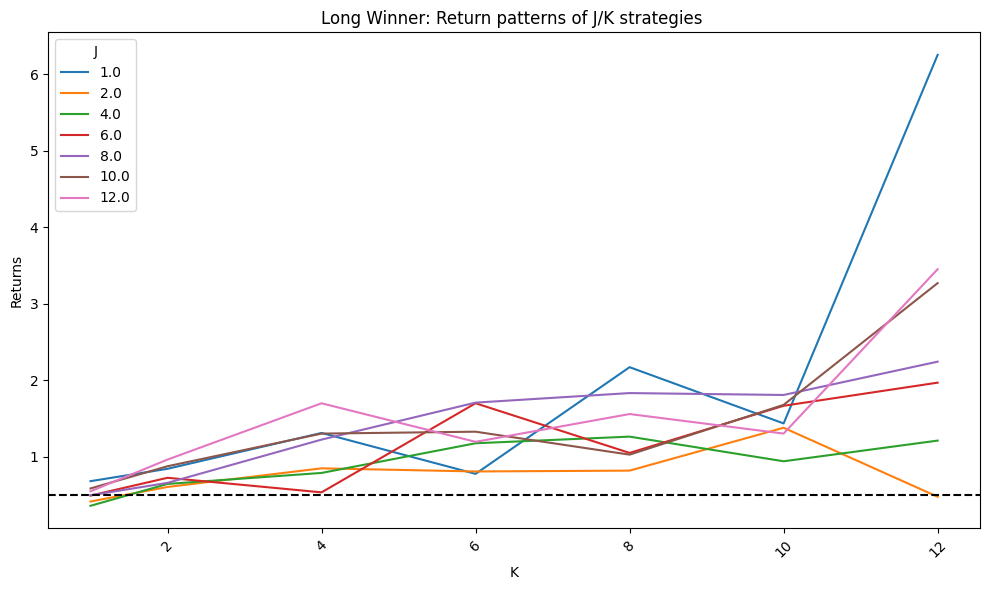

In [53]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for category, group_df in longWinners_p.groupby('J'):
    ax.plot(group_df['K'], group_df['Return'], label=category)

ax.set_title('Long Winner: Return patterns of J/K strategies ')
ax.set_xlabel('K')
ax.set_ylabel('Returns')
ax.legend(title='J')
plt.xticks(rotation=45)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [54]:
loser_pivoted_quantity_return = longLosers_p.pivot(index='J', columns='K', values='Return')
loser_pivoted_quantity_return

K,1.0,2.0,4.0,6.0,8.0,10.0,12.0
J,,,,,,,
1.0,-0.067360,-0.254141,-0.457164,-0.413522,-0.581831,-0.414109,-0.538131
2.0,-0.202584,-0.208856,-0.485157,-0.423772,-0.490322,-0.554781,-0.501413
4.0,-0.228228,-0.344854,-0.266286,-0.554583,-0.560045,-0.726392,-0.711482
6.0,-0.103571,-0.225678,-0.474600,-0.417892,-0.538564,-0.641622,-0.682260
8.0,-0.268555,-0.423633,-0.412916,-0.134006,-0.415146,-0.589709,-0.674620
10.0,-0.187221,-0.247907,-0.386246,-0.461114,-0.428775,-0.330076,-0.567256
12.0,-0.031582,-0.229018,-0.200757,-0.465623,-0.656856,-0.508143,-0.629942


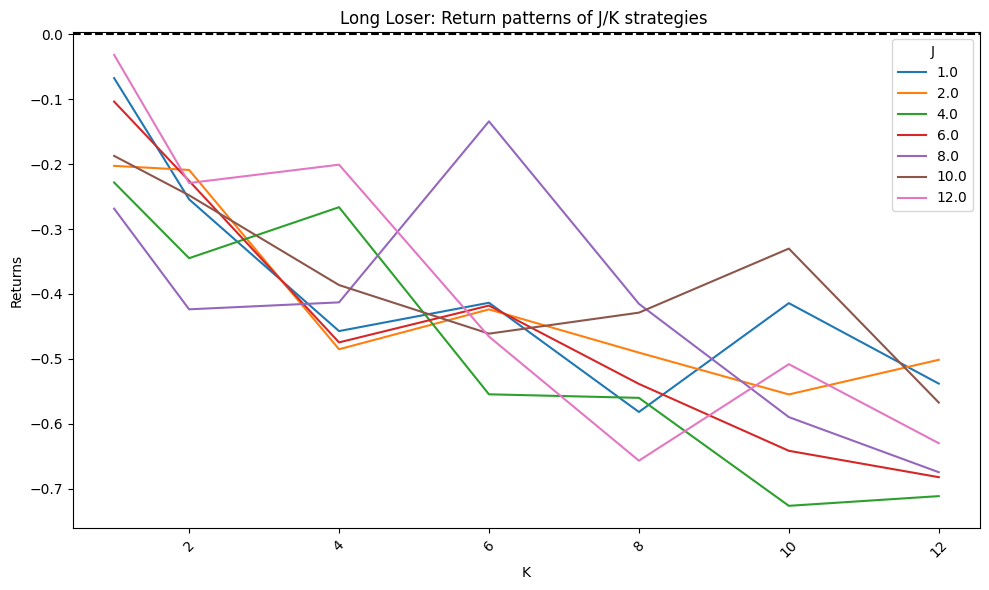

In [55]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for category, group_df in longLosers_p.groupby('J'):
    ax.plot(group_df['K'], group_df['Return'], label=category)

ax.set_title('Long Loser: Return patterns of J/K strategies ')
ax.set_xlabel('K')
ax.set_ylabel('Returns')
ax.legend(title='J')
plt.xticks(rotation=45)
plt.axhline(y=0.0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# Expansion : Returns of J/1 strategies
---

In [ ]:
overallJKRebal_exp = pd.DataFrame(columns = ['J','K','Initital Investment', 'Profit (Stock Diff)'])

for j in range(1,105):
    initialInvestmentW = 1000
    # This line is just here for sanity, you can comment it out if you want. Lets us know code is 
    # still running
    print(j)

    # J wi
    J = j
    K = 1

    # starting date
    sY = 2014
    sW = 1

    # ending date
    eW = 52
    eY = 2023
    
    iY = 2014
    iW = 1
    if(iW - J) <= 0:
        iW = J + 1
        if iW > 53:
            iW -= 53
            iY = iY + 1
    
    tempP = 1000
    
    p = 0
    
    transactions = None
    total = 0
    totalP = 0 

    # We need to rebalance which means we need a starting point and a target
    # point
    starting_universe, d_start = getUniverseWeights(iW, iY, J, 1000, data)
    while iW < eW or iY < eY:
        if(starting_universe is None):
            print('Here')
            iW, iY = adjust_week_year(iW, iY, K)
            continue
        sW = iW
        sY = iY
        iW, iY = adjust_week_year(iW, iY, K)
        
        #print(sY, '/', sW, ' to ', iY, '/', iW ) # Sanity check line, can comment out

        # let us now get the ending universe of stocks. Our investment will always be 1000.
        # this is our assumption
        ending_universe, d_end = getUniverseWeights(iW, iY, J, 1000, data)
        
        # Now we will look at rebalancing it
        transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
        if transactions is not None:
            # transaction holds the value of changes to be made
            #p, q, l = calculate_profit(transactions)
            p = calculate_profit_closing_positions(transactions)
            total = total + 1
            totalP = totalP + p
            initialInvestmentW += p
            if (p < 0):
                tempP = tempP + abs(p)
            
           # print( ' Profit = $', p, ' Investment for this now: ', initialInvestmentW, ' Current Profit = $', totalP)
        # POST REBALANCING
        starting_universe = ending_universe
        
    iW, iY = adjust_week_year(iW, iY, K)
    # we now need to close off our final positions
    ending_universe, d_end = getUniverseWeights(iW, iY, J, initialInvestmentW, data)
    transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
    if transactions is not None:
        # transaction holds the value of changes to be made
        p = calculate_profit_closing_positions(transactions)
        total = total + 1
        totalP = totalP + p
        if (p < 0):
            tempP = tempP + abs(p)
        #qq = transactions
            
    
    overallJKRebal_exp.loc[len(overallJKRebal_exp.index)] = [J, K, tempP, totalP]
    overallJKRebal_exp.to_csv('PaperSubmissionExpJ=1_104K=1.csv')
    print('------------')

In [24]:
# Time to calculate the returns
overallJKRebal_exp['Return (Stock Diff)'] = overallJKRebal_exp['Profit (Stock Diff)'] / (overallJKRebal_exp['Initital Investment'])

overallJKRebal_exp.head()

,J,K,Initital Investment,Profit (Stock Diff),Return (Stock Diff)
0,1.0,1.0,13390.755028,6950.079927,0.519021
1,2.0,1.0,16278.724814,3426.554738,0.210493
2,3.0,1.0,15722.413316,4091.057810,0.260205
3,4.0,1.0,15835.900231,2625.452887,0.165791
4,5.0,1.0,15846.208419,2384.709159,0.150491


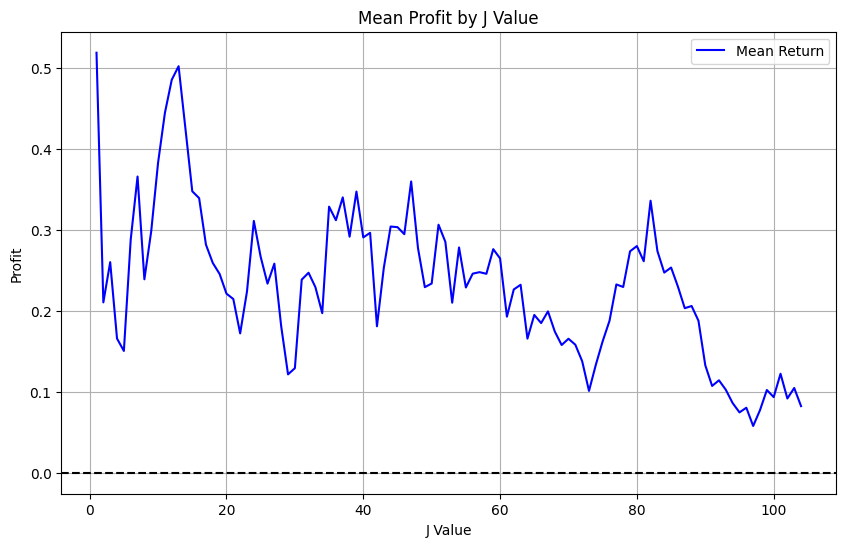

In [25]:
# Lets plot the returns
grouped_data = overallJKRebal_exp.groupby('J')['Return (Stock Diff)'].agg(['mean', 'count', 'std'])
confidence_level = 0.95

plt.figure(figsize=(10, 6))
plt.plot(grouped_data.index, grouped_data['mean'], '-', color='b', label='Mean Return')
plt.xlabel('J Value')
plt.ylabel('Profit')
plt.title('Mean Profit by J Value')
plt.axhline(y=0, color='k', linestyle='--')  # Adds a horizontal line at zero for reference
plt.legend()
plt.grid(True)
plt.show()

# Expansion of Average returns on J/K strategies with weekly rebalancing
---

In [ ]:
overall_exp = pd.DataFrame(columns = ['J','K','Initital Investment', 'Profit'])
J = [1, 2, 4, 6, 8, 10, 12]
K = [1, 2, 4, 6, 8, 10, 12]
for j in J:
    JJ = j
    for k in K:
        initialInvestmentW = 1000
        initialInvestment = 1000
        print(j, k)
        KK = k
        eW = 53
        eY = 2023
        
        iY = 2014
        iW = 1
        if(iW - JJ) < 0:
            iW = JJ + 1
            if iW > 53:
                iW -= 53
                iY = iY + 1
                
        tempP = 1000
        tempL = 1000
        p = 0
        q = 0
        pQ = 0

        transactions = None
        total = 0
        totalP = 0 
        totalQ = 0
        totalL = 0
        starting_universe, d_start = getUniverseWeights(iW, iY, JJ, 1000, data)
        while (iW < eW and iY < eY) or iY <= eY:
            if(starting_universe is None):
                print('Here')
                iW, iY = adjust_week_year(iW, iY, KK)
                continue
            sW = iW
            sY = iY

            # This part of the code will focus on weekly rebalancing
            for week in range(KK - 1):
                iW += 1  # Move to the next week
                if iW > 53:
                    iW = 1
                    iY += 1
                #print('Weekly: ', sY, '/', sW, ' to ', iY, '/', iW )
                weekly_universe, d_end = getUniverseWeights(iW, iY, JJ, 1000, data)
                #transactions = rebalancePortfolio(starting_universe, weekly_universe, d_end)
                if transactions is not None:
                    p = calculate_weekly(transactions)
                    totalP = totalP + p
                    initialInvestmentW += p
                    if (p < 0):
                        tempP = tempP + abs(p)
                    qq = transactions
                starting_universe = weekly_universe
            
            # This part of the code focuses on closing the final positions
            iW, iY = adjust_week_year(sW, sY, KK)
            #print(sY, '/', sW, ' to ', iY, '/', iW )
    
            # let us now get the ending universe of stocks
            ending_universe, d_end = getUniverseWeights(iW, iY, JJ, 1000, data)
            
            # Now we will look at rebalancing it
            transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
            #print( ' Investment for this now: ', initialInvestmentW, ' Current Profit = $', totalP)
            #print(transactions)
            if transactions is not None:
                # transaction holds the value of changes to be made
                #p, q, l = calculate_profit(transactions)
                pr = calculate_profit_closing_positions(transactions)
                total = total + 1
                totalP = totalP + pr
                totalQ = totalQ + q
                initialInvestmentW += pr
                if (pr < 0):
                    tempP = tempP + abs(pr)
                
                qq = transactions
                
                #print( ' Profit = $', pr, ' Investment for this now: ', initialInvestmentW, ' Current Profit = $', totalP)
                #print('---')
            # POST REBALANCING
            starting_universe = ending_universe
            
        iW, iY = adjust_week_year(iW, iY, KK)
        # we now need to close off our final positions
        ending_universe, d_end = getUniverseWeights(iW, iY, JJ, initialInvestmentW, data)
        transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
        if transactions is not None:
            # transaction holds the value of changes to be made
            p = calculate_profit_closing_positions(transactions)
            total = total + 1
            totalP = totalP + p
            totalQ = totalQ + q
            if (p < 0):
                    tempP = tempP + abs(p)
            #qq = transactions
        overall_exp.loc[len(overall_exp.index)] = [ JJ, KK, tempP, totalP]
        overall_exp.to_csv('PaperSubmissionMultipleExpJ=1_12,k=1_12_.csv')

In [65]:
# overall_exp = pd.read_csv("PaperSubmissionMultipleExpJ=1_12,k=1_12_.csv")
# overall_exp = overall_exp.loc[:, ~overall_exp.columns.str.contains('^Unnamed')]

overall_exp['Return'] = overall_exp['Profit'] / overall_exp['Initital Investment']
overall_exp_p = overall_exp[['J','K','Return']]

In [66]:
pivoted_return_ext = overall_exp_p.pivot(index='J', columns='K', values='Return')
pivoted_return_ext

K,1.0,2.0,4.0,6.0,8.0,10.0,12.0
J,,,,,,,
1.0,0.519021,0.299514,0.030715,-0.078648,-0.143637,0.285887,0.026820
2.0,0.210493,0.015864,0.329562,-0.269414,0.470586,-0.575412,0.477996
4.0,0.165791,0.350568,0.347310,1.767538,0.721546,0.297766,1.534991
6.0,0.288070,0.611754,0.755091,0.616809,1.238336,1.682698,1.258578
8.0,0.239032,0.346519,0.396027,0.488028,0.550515,0.170961,0.408150
10.0,0.383066,0.446650,0.487226,0.803216,0.327921,1.236551,1.415265
12.0,0.485561,0.509489,0.471718,0.809292,0.295564,0.133103,0.562207


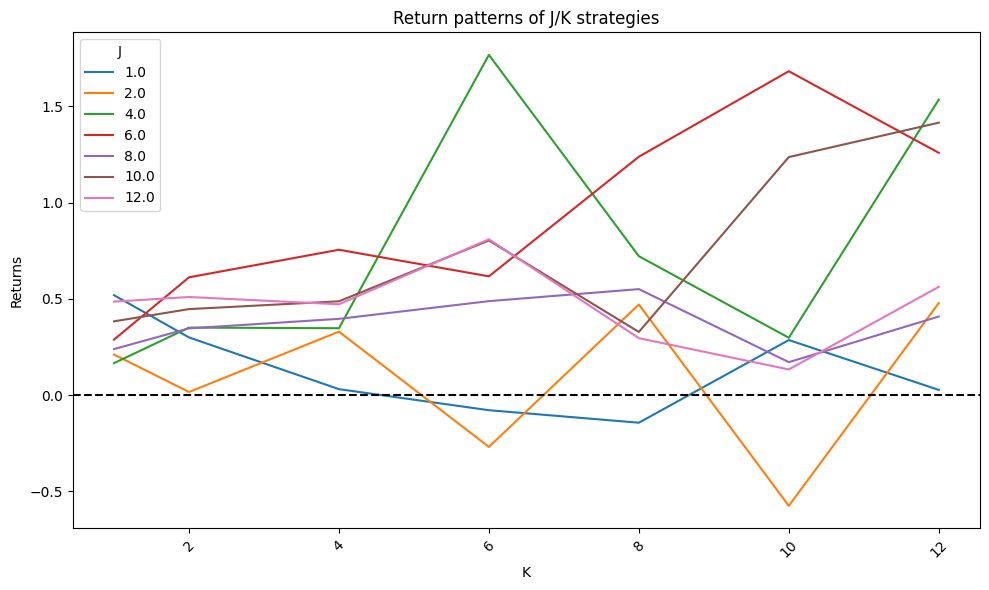

In [67]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for category, group_df in overall_exp_p .groupby('J'):
    ax.plot(group_df['K'], group_df['Return'], label=category)

ax.set_title('Return patterns of J/K strategies')
ax.set_xlabel('K')
ax.set_ylabel('Returns')
ax.legend(title='J')
plt.xticks(rotation=45)
plt.axhline(y=0.0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# Expansion of Winners and Losers, Seperately
---

In [ ]:
longWinners_exp = pd.DataFrame(columns = ['J','K','Initital Investment', 'Profit'])
J = [1, 2, 4, 6, 8, 10, 12]
K = [1, 2, 4, 6, 8, 10, 12]
for j in J:
    JJ = j
    for k in K:
        initialInvestmentW = 1000
        initialInvestment = 1000
        print(j, k)
        KK = k
        eW = 52
        eY = 2023
        
        iY = 2014
        iW = 1
        if(iW - JJ) < 0:
            iW = JJ + 1
            if iW > 53:
                iW -= 53
                iY = iY + 1
        
        tempP = 1000
        tempL = 1000
        p = 0
        q = 0
        pQ = 0

        transactions = None
        total = 0
        totalP = 0 
        totalQ = 0
        totalL = 0
        starting_universe, d_start = getUniverseWeights(iW, iY, JJ, 1000, data, True)
        while (iW < eW and iY < eY) or iY <= eY:
            if(starting_universe is None):
                print('Here')
                iW, iY = adjust_week_year(iW, iY, KK)
                continue
            sW = iW
            sY = iY
            iW, iY = adjust_week_year(iW, iY, KK)
            #print(sY, '/', sW, ' to ', iY, '/', iW )
    
            # let us now get the ending universe of stocks
            ending_universe, d_end = getUniverseWeights(iW, iY, JJ, 1000, data, True)
            # Now we will look at rebalancing it
            transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
            if transactions is not None:
                # transaction holds the value of changes to be made
                #p, q, l = calculate_profit(transactions)
                p = calculate_profit_closing_positions(transactions)
                total = total + 1
                totalP = totalP + p
                totalQ = totalQ + q
                initialInvestmentW += p
                if (p < 0):
                    tempP = tempP + abs(p)
                qq = transactions
                
                # initialInvestmentW = initialInvestmentW + q
                #print( ' Profit = $', p, ' Investment for this now: ', initialInvestmentW, ' Current Profit = $', totalP)
            # POST REBALANCING
            starting_universe = ending_universe
            
        iW, iY = adjust_week_year(iW, iY, KK)
        # we now need to close off our final positions
        ending_universe, d_end = getUniverseWeights(iW, iY, JJ, initialInvestmentW, data, True)
        transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
        if transactions is not None:
            # transaction holds the value of changes to be made
            p = calculate_profit_closing_positions(transactions)
            total = total + 1
            totalP = totalP + p
            totalQ = totalQ + q
            
            if (p < 0):
                    tempP = tempP + abs(p)
            #qq = transactions
        longWinners_exp.loc[len(longWinners_exp.index)] = [ JJ, KK, tempP, totalP]
        longWinners_exp.to_csv('PaperSSubmissionLongWinnersExpMultipleJ=1_12,k=1_12_.csv')

In [58]:
longWinners_exp['Return'] = longWinners_exp['Profit'] / longWinners_exp['Initital Investment']
longWinners_exp_p = longWinners_exp[['J','K','Return']]

winner_pivoted_quantity_return = longWinners_exp_p.pivot(index='J', columns='K', values='Return')
winner_pivoted_quantity_return

K,1.0,2.0,4.0,6.0,8.0,10.0,12.0
J,,,,,,,
1.0,0.586151,0.732397,1.045006,0.657991,1.837027,1.198404,4.139395
2.0,0.372577,0.511362,0.681839,0.687989,0.675894,0.935163,0.347008
4.0,0.326462,0.531172,0.552179,0.830497,0.846984,0.705340,0.892217
6.0,0.387214,0.592535,0.423284,1.293716,0.788853,1.131391,1.580389
8.0,0.400096,0.524490,0.847985,1.302771,1.374441,1.260551,1.708508
10.0,0.453912,0.665877,0.935547,0.960946,0.771529,1.430135,2.492796
12.0,0.458190,0.779082,1.270911,1.018159,1.165738,1.032560,2.590385


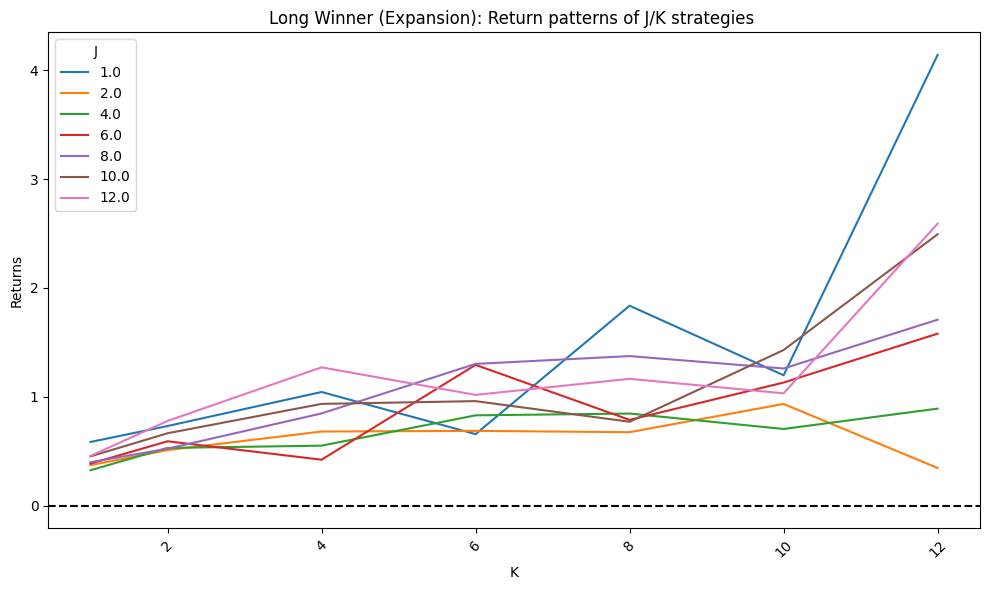

In [60]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for category, group_df in longWinners_exp_p.groupby('J'):
    ax.plot(group_df['K'], group_df['Return'], label=category)

ax.set_title('Long Winner (Expansion): Return patterns of J/K strategies ')
ax.set_xlabel('K')
ax.set_ylabel('Returns')
ax.legend(title='J')
plt.xticks(rotation=45)
plt.axhline(y=0.0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
longLosers_exp = pd.DataFrame(columns = ['J','K','Initital Investment', 'Profit'])
J = [1, 2, 4, 6, 8, 10, 12]
K = [1, 2, 4, 6, 8, 10, 12]
for j in J:
    JJ = j
    for k in K:
        initialInvestmentW = 1000
        initialInvestment = 1000
        print(j, k)
        KK = k
        eW = 52
        eY = 2023
        
        iY = 2014
        iW = 1
        if(iW - JJ) < 0:
            iW = JJ + 1
            if iW > 53:
                iW -= 53
                iY = iY + 1
        
        tempP = 1000
        tempL = 1000
        p = 0
        q = 0
        pQ = 0

        transactions = None
        total = 0
        totalP = 0 
        totalQ = 0
        totalL = 0
        starting_universe, d_start = getUniverseWeights(iW, iY, JJ, 1000, data, False)
        while (iW < eW and iY < eY) or iY <= eY:
            if(starting_universe is None):
                print('Here')
                iW, iY = adjust_week_year(iW, iY, KK)
                continue
            sW = iW
            sY = iY
            iW, iY = adjust_week_year(iW, iY, KK)
            #print(sY, '/', sW, ' to ', iY, '/', iW )
    
            # let us now get the ending universe of stocks
            ending_universe, d_end = getUniverseWeights(iW, iY, JJ, 1000, data, False)
            # Now we will look at rebalancing it
            transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
            if transactions is not None:
                # transaction holds the value of changes to be made
                #p, q, l = calculate_profit(transactions)
                p = calculate_profit_closing_positions(transactions)
                total = total + 1
                totalP = totalP + p
                totalQ = totalQ + q
                initialInvestmentW += p
                if (p < 0):
                    tempP = tempP + abs(p)
                qq = transactions
                
                # initialInvestmentW = initialInvestmentW + q
               # print( ' Profit = $', p, ' Investment for this now: ', initialInvestmentW, ' Current Profit = $', totalP)
            # POST REBALANCING
            starting_universe = ending_universe
            
        iW, iY = adjust_week_year(iW, iY, KK)
        # we now need to close off our final positions
        ending_universe, d_end = getUniverseWeights(iW, iY, JJ, initialInvestmentW, data, False)
        transactions = rebalancePortfolio(starting_universe, ending_universe, d_end)
        if transactions is not None:
            # transaction holds the value of changes to be made
            p = calculate_profit_closing_positions(transactions)
            total = total + 1
            totalP = totalP + p
            totalQ = totalQ + q
            if (p < 0):
                    tempP = tempP + abs(p)
            #qq = transactions
        longLosers_exp.loc[len(longLosers_exp.index)] = [ JJ, KK, tempP, totalP]
        longLosers_exp.to_csv('LongLosersExpMultipleJ=1_12,k=1_12_.csv')

In [62]:
longLosers_exp['Return'] = longLosers_exp['Profit'] / longLosers_exp['Initital Investment']
longLosers_exp_p = longLosers_exp[['J','K','Return']]

loser_pivoted_quantity_return = longLosers_exp_p.pivot(index='J', columns='K', values='Return')
loser_pivoted_quantity_return

K,1.0,2.0,4.0,6.0,8.0,10.0,12.0
J,,,,,,,
1.0,-0.028076,-0.221256,-0.397683,-0.357680,-0.545422,-0.408090,-0.463188
2.0,-0.174224,-0.226886,-0.479965,-0.401159,-0.418062,-0.576488,-0.432517
4.0,-0.237845,-0.359069,-0.308662,-0.594772,-0.558000,-0.681815,-0.652950
6.0,-0.160498,-0.246770,-0.455752,-0.357217,-0.476750,-0.595560,-0.618802
8.0,-0.287630,-0.402394,-0.416742,0.022131,-0.361277,-0.539379,-0.614437
10.0,-0.161845,-0.217887,-0.302847,-0.399462,-0.357443,-0.298941,-0.536541
12.0,0.000408,-0.183476,-0.183954,-0.364845,-0.633602,-0.477326,-0.499448


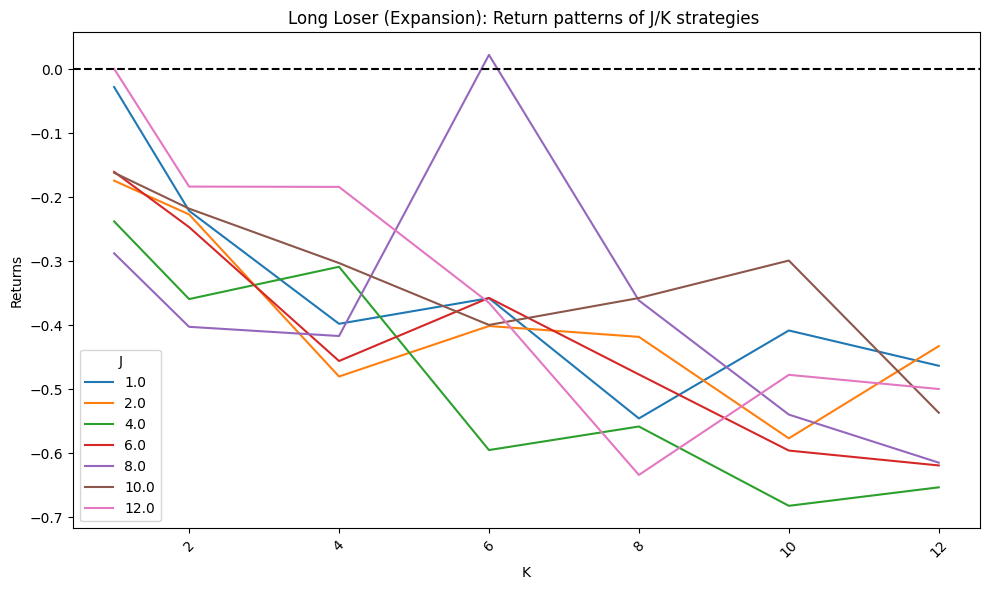

In [63]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for category, group_df in longLosers_exp_p.groupby('J'):
    ax.plot(group_df['K'], group_df['Return'], label=category)

ax.set_title('Long Loser (Expansion): Return patterns of J/K strategies ')
ax.set_xlabel('K')
ax.set_ylabel('Returns')
ax.legend(title='J')
plt.xticks(rotation=45)
plt.axhline(y=0.0, color='black', linestyle='--')
plt.tight_layout()
plt.show()